# Making a recurrent spiking neural network model from scratch

1. Import all necessary libraries, I will focus on using pytorch here.
1.1. Define some quick helper functions.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Module, Parameter, init
from torch.optim import Adam
from typing import Callable
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def sparsify_matrix(mat, p=1.0):
    """helper function to make weight matrices sparse if desired."""
    new_mat = mat.clone()
    new_mat[torch.rand_like(mat) > p] = 0.

    return new_mat

def simple_spike(mem):

    return (mem > 0.).float()

2. Define the spiking neuron layer. This class is not complete and hence documentation will be added later.

In [4]:
class FLIF(Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = False,
                 device=None, dtype=None, dt=1e-3, spike_func: Callable = simple_spike,
                 train_v0: bool = False,
                 train_threshold: bool = False, threshold_std: float = 0.0, threshold_delta_max: float = 1.,
                 train_threshold_tau: bool = False, threshold_tau_mean: float = 0.99, threshold_tau_std: float = 0.0,  # look up plausible values
                 train_V_tau: bool = False, V_tau_mean: float = 10e-3, V_tau_std: float = 0.0,
                 train_I_tau: bool = False, I_tau_mean: float = 5e-3, I_tau_std: float = 0.0,
                 input_dropout: float = 0.0, input_density: float = 1.0,
                 recurrent_dropout: float = 0.0, recurrent_density: float = 1.0
                 ) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(FLIF, self).__init__()
        self.in_features = in_features    # inputs
        self.out_features = out_features  # N neurons

        self.dt = dt                      # sim time step size
        self.spike_func = spike_func      # this is where surrogate gradients happen

        self.train_V0 = train_v0                           # initial membrane potential state
        self.train_threshold = train_threshold             # makes neuron threshold jump at spike
        self.threshold_std = threshold_std
        self.threshold_delta_max = threshold_delta_max
        self.train_threshold_tau = train_threshold_tau     # threshold decay time constant
        self.threshold_tau_mean = threshold_tau_mean
        self.threshold_tau_std = threshold_tau_std
        self.train_V_tau = train_V_tau                     # membrane decay time constant
        self.V_tau_mean = V_tau_mean
        self.V_tau_std = V_tau_std
        self.train_I_tau = train_I_tau                     # synapse decay time constant
        self.I_tau_mean = I_tau_mean
        self.I_tau_std = I_tau_std

        self.input_con = nn.Linear(in_features, out_features, False, device, dtype)  # make sparse?
        self.recurrent_con = nn.Linear(out_features, out_features, False, device, dtype)  # make sparse or factorize?
        self.input_dropout = input_dropout
        self.recurrent_dropout = recurrent_dropout
        self.input_density = input_density
        self.recurrent_density = recurrent_density

        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)

        self.V_rest = torch.zeros(out_features, **factory_kwargs)
        self.V_0 = Parameter(torch.empty(out_features, **factory_kwargs), requires_grad=self.train_V0)
        self.threshold = Parameter(torch.empty(out_features, **factory_kwargs), requires_grad=self.train_threshold)
        self.threshold_delta = torch.empty(out_features, **factory_kwargs)
        self.threshold_tau = Parameter(torch.empty(out_features, **factory_kwargs), requires_grad=self.train_threshold_tau)            # threshold decay time constant
        self.V_tau = Parameter(torch.empty(out_features, **factory_kwargs), requires_grad=self.train_V_tau)
        self.I_tau = Parameter(torch.empty(out_features, **factory_kwargs), requires_grad=self.train_I_tau)

        self.state_initialized = False

        self.reset_parameters()

    def reset_parameters(self) -> None:

        init.kaiming_normal_(self.input_con.weight)         # adapt ?
        if self.input_density < 1.:
            self.input_con.weight.data = sparsify_matrix(self.input_con.weight.data, self.input_density)   # TODO: make this a hyperparamter
        self.input_con.weight.data *= 0.05
        init.kaiming_normal_(self.recurrent_con.weight)     # adapt ?
        if self.recurrent_density < 1.:
            self.recurrent_con.weight.data = sparsify_matrix(self.recurrent_con.weight.data, self.recurrent_density)   # TODO: make this a hyperparamter
        #self.recurrent_con.weight.data *= 0.1
        init.zeros_(self.V_0)
        if self.threshold_std > 0.:
            init.trunc_normal_(self.threshold, mean=1., std=self.threshold_std, a=0.5, b=1.5)
        else:
            init.ones_(self.threshold)
        init.uniform_(self.threshold_delta, 0, self.threshold_delta_max)    # replace 0 by - self.threshold_delta_max?
        if self.threshold_tau_std > 0.:
            init.trunc_normal_(self.threshold_tau, mean=self.threshold_tau_mean, std=self.threshold_tau_std, a=0., b=1.)
        else:
            init.constant_(self.threshold_tau, self.threshold_tau_mean)
        if self.V_tau_std > 0.:
            init.trunc_normal_(self.V_tau, mean=self.V_tau_mean, std=self.V_tau_std, a=0., b=1.)
        else:
            init.constant_(self.V_tau, self.V_tau_mean)
        if self.I_tau_std > 0.:
            init.trunc_normal_(self.I_tau, mean=self.I_tau_mean, std=self.I_tau_std, a=0., b=1.)
        else:
            init.constant_(self.I_tau, self.I_tau_mean)
        if self.bias is not None:   # adjust to sensible value
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.recurrent_con.weight)
            bound = 0.1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def init_state(self, batch_size):

        self.V_t = self.V_0.repeat((batch_size, 1))
        self.I_t = torch.zeros((batch_size, self.out_features), device=self.V_0.device)
        self.threshold_eff = self.threshold.repeat((batch_size, 1))
        self.spk = torch.zeros((batch_size, self.out_features), device=self.V_0.device)   # change dtype ?
        self.state_initialized = True

    def forward(self, inpt) -> Tensor:

        if not self.state_initialized:
            self.init_state(inpt.shape[0])

        # make spike
        V_shift = self.V_t - self.threshold_eff
        # TODO: make surrogate gradient function here like
        # https://snntorch.readthedocs.io/en/latest/_modules/snntorch/surrogate.html#ATan
        self.spk = self.spike_func(V_shift)

        # adjust threshold if spiked
        self.threshold_eff = self.threshold_tau * (self.threshold_eff - self.threshold) + self.threshold + self.threshold_delta * self.spk

        # integrate new input
        I_in = F.dropout(self.input_con(inpt), self.input_dropout, True, False)
        I_rec = F.dropout(self.recurrent_con(self.spk), self.recurrent_dropout, True, False)

        alpha = torch.exp(-self.dt/self.I_tau)
        beta  = torch.exp(-self.dt/self.V_tau)

        self.I_t = alpha * self.I_t + I_in + I_rec
        if self.bias is not None:
            self.I_t = self.I_t + self.bias
        self.V_t = beta * self.V_t + self.I_t - self.spk * self.threshold_eff     # subtractive method

        return self.spk

3. Define a leaky, but *non-spiking* readout layer. The membrane potential variable V(t) of this layer will be the network output we optimize.

In [5]:
class Readout(Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = False,
                 device=None, dtype=None, dt=1e-3,
                 train_V_tau: bool = False, V_tau_mean: float = 10e-3, V_tau_std: float = 0.0,
                 train_I_tau: bool = False, I_tau_mean: float = 5e-3, I_tau_std: float = 0.0,
                 input_dropout: float = 0.0, input_density: float = 1.0,
                 ) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Readout, self).__init__()
        self.in_features = in_features    # inputs
        self.out_features = out_features  # N neurons

        self.dt = dt                      # sim time step size

        self.train_V_tau = train_V_tau                     # membrane decay time constant
        self.V_tau_mean = V_tau_mean
        self.V_tau_std = V_tau_std
        self.train_I_tau = train_I_tau                     # synapse decay time constant
        self.I_tau_mean = I_tau_mean
        self.I_tau_std = I_tau_std

        self.input_con = nn.Linear(in_features, out_features, False, device, dtype)  # make sparse?
        self.input_dropout = input_dropout
        self.input_density = input_density

        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)

        self.V_rest = torch.zeros(out_features, **factory_kwargs)
        self.V_0 = Parameter(torch.empty(out_features, **factory_kwargs), requires_grad=False)
        self.V_tau = Parameter(torch.empty(out_features, **factory_kwargs), requires_grad=self.train_V_tau)
        self.I_tau = Parameter(torch.empty(out_features, **factory_kwargs), requires_grad=self.train_I_tau)

        self.state_initialized = False

        self.reset_parameters()

    def reset_parameters(self) -> None:

        init.kaiming_normal_(self.input_con.weight)         # adapt ?
        if self.input_density < 1.:
            self.input_con.weight.data = sparsify_matrix(self.input_con.weight.data, self.input_density)   # TODO: make this a hyperparamter
        self.input_con.weight.data *= 0.05
        init.zeros_(self.V_0)

        if self.V_tau_std > 0.:
            init.trunc_normal_(self.V_tau, mean=self.V_tau_mean, std=self.V_tau_std, a=0., b=1.)
        else:
            init.constant_(self.V_tau, self.V_tau_mean)
        if self.I_tau_std > 0.:
            init.trunc_normal_(self.I_tau, mean=self.I_tau_mean, std=self.I_tau_std, a=0., b=1.)
        else:
            init.constant_(self.I_tau, self.I_tau_mean)
        if self.bias is not None:   # adjust to sensible value
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.recurrent_con.weight)
            bound = 0.1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def init_state(self, batch_size):

        self.V_t = self.V_0.repeat((batch_size, 1))
        self.I_t = torch.zeros((batch_size, self.out_features), device=self.V_0.device)
        self.state_initialized = True

    def forward(self, inpt) -> Tensor:

        if not self.state_initialized:
            self.init_state(inpt.shape[0])

        # integrate new input
        I_in = F.dropout(self.input_con(inpt), self.input_dropout, True, False)

        alpha = torch.exp(-self.dt/self.I_tau)
        beta  = torch.exp(-self.dt/self.V_tau)

        self.I_t = alpha * self.I_t + I_in
        if self.bias is not None:
            self.I_t = self.I_t + self.bias
        self.V_t = beta * self.V_t + self.I_t

        return self.V_t

3. Make some dummy input data.

In [6]:
# Create some dummy data to put through the network.
# This data has a single dimension, but we will use a batch size of 3.

X1 = torch.linspace(0., 4 * math.pi, 1001)
X2 = torch.linspace(0., 1.5 * math.pi, 1001)
X3 = torch.linspace(0., 10. * math.pi, 1001)
X = torch.stack([X1, X2, X3], dim=1).sin().unsqueeze(-1)
X_init = torch.zeros((250, 3, 1))
X = torch.vstack([X_init, X])

print(X.shape)
T = X.shape[0]
batch_size = X.shape[1]

torch.Size([1251, 3, 1])


4. Define a some plotting functions that will be helpful to see what is going on.

In [7]:
# One function for plotting spike patterns.
def raster_plot(spikes, ax=None):
    if ax is None:
        ax = plt.axes()
    ax.imshow(spikes.cpu().t(), cmap=plt.cm.gray_r, aspect="auto", interpolation='none')
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Unit")

# Another to plot any continuous variable over time.
def plot_traces(trace, spk = None, dim = (3,5), spike_height = 10, ylabel='V(t)'):
    fig = plt.figure(figsize=(10, 4))
    gs = plt.GridSpec(*dim, figure=fig)
    if spk is not None:
        dat = 1.0*trace
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = trace.detach().cpu().numpy()
    for i in range(math.prod(dim)):
        if i==0:
            a0=ax=plt.subplot(gs[i])
        else:
            ax=plt.subplot(gs[i],sharey=a0)
        ax.axis("off")
        ax.plot(dat[i])
        if i == (dim[0] - 1) * dim[1]:
            print(i)
            ax.axis("on")
            ax.spines[['right', 'top']].set_visible(False)
            ax.set_ylabel(ylabel)
            ax.set_xlabel('t [ms]')

5. Feed the data through the network and record the activity so we can take a look at it.

torch.Size([3, 1251, 100])


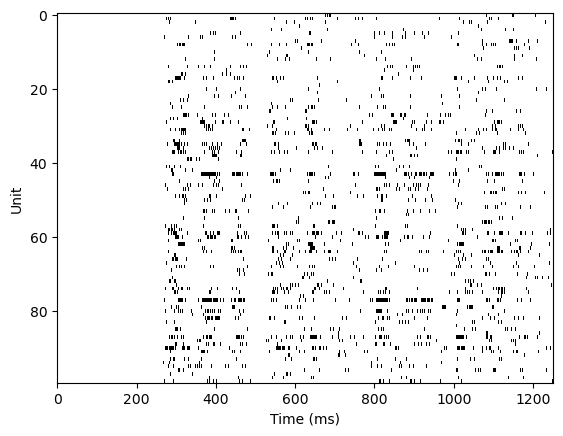

2


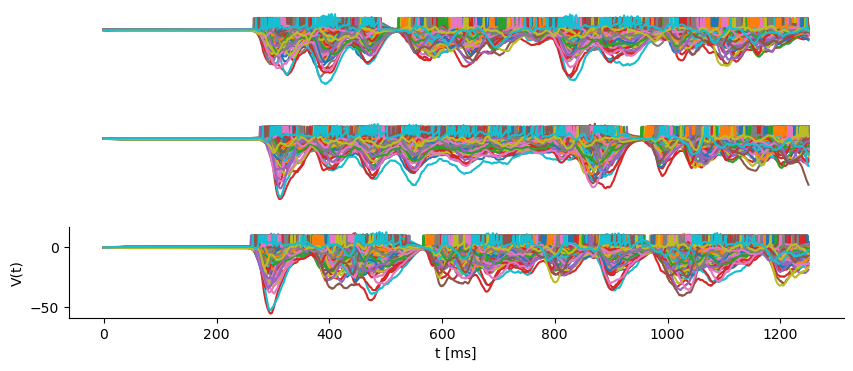

In [32]:
# Initiate the spiking model with 1 input and 100 hidden units
n_hidden = 100
flif = FLIF(1, n_hidden, bias=True)
flif.init_state(batch_size)

verbose = False
if verbose:
    print(flif.spk)
    print(flif.V_t)
    print(flif.threshold_eff)
    print()

# Record some of the internal variables for plotting.
spikes = []
membrane = []
threshold = []
current = []

# Iterate over the time points in the data and feed it through the network
for t in range(T):
    spk = flif(X[t])
    spikes.append(spk)
    membrane.append(flif.V_t)
    threshold.append(flif.threshold_eff)
    current.append(flif.I_t)
    if verbose:
        print(t)
        print(flif.spk)
        print(flif.V_t)
        print(flif.threshold_eff)
        print()

# Turn the recorded variables into the right shape for easy plotting.
spikes = torch.stack(spikes, 1)
membrane = torch.stack(membrane, 1)
threshold = torch.stack(threshold, 1)
current = torch.stack(current, 1)
print(spikes.shape)

# plot the spikes
data_id = 0
raster_plot(spikes[data_id])
plt.show()

# plot the membrane potential
plot_traces(membrane, spikes, dim=(3, 1))
plt.show()

2


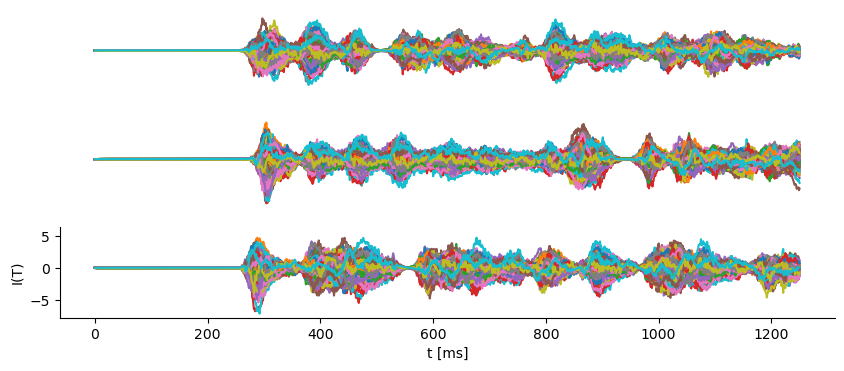

In [33]:
plot_traces(current, dim=(3,1), ylabel='I(T)')

2


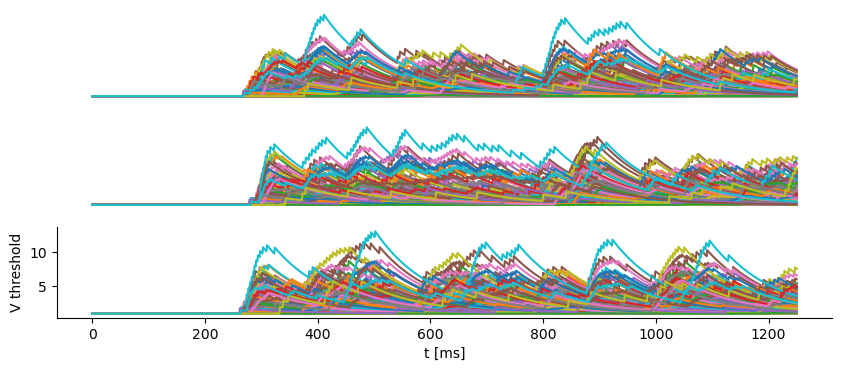

In [34]:
plot_traces(threshold, dim=(3, 1), ylabel='V threshold')

6. Let's define a readout layer and see what the signal looks like.

2


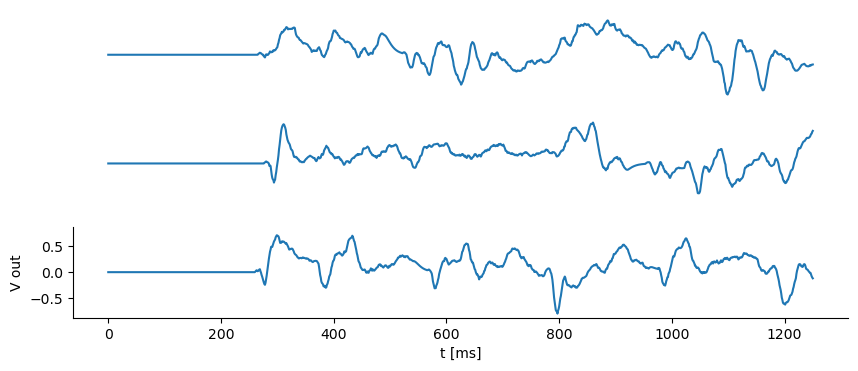

In [35]:
readout = Readout(100, 1)

V_outs = []
for spk in spikes.transpose(0, 1):
    V_out = readout(spk)
    V_outs.append(V_out)

V_outs = torch.stack(V_outs, 1)
# print(V_outs.shape)

plot_traces(V_outs, dim=(3, 1), ylabel='V out')

7. The output is pretty random. Let's try to reconstruct the input by only adapting the readout weight matrix

initial reconstruction
2


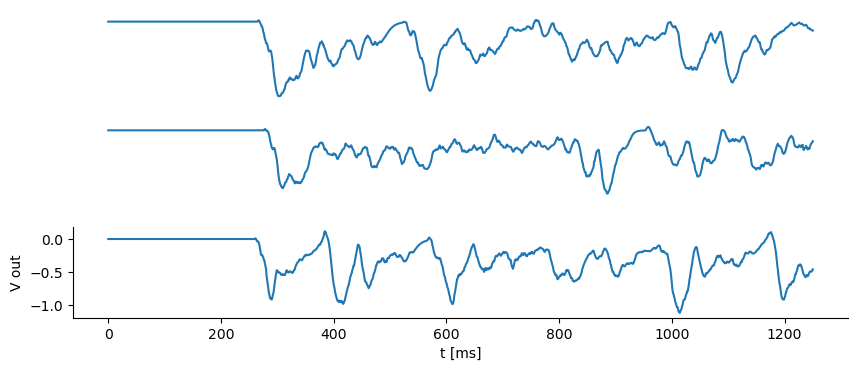

0 0.5778731107711792
1 0.448373407125473
2 0.38276568055152893
3 0.34563377499580383
4 0.3198832869529724
5 0.2977515459060669
6 0.27568432688713074
7 0.2521180808544159
8 0.22671137750148773
9 0.20012971758842468
10 0.174006849527359
11 0.15089081227779388
12 0.13394363224506378
13 0.12596894800662994
14 0.12730060517787933
15 0.1335494965314865
16 0.13710682094097137
17 0.13292230665683746
18 0.12158697843551636
19 0.10729723423719406
20 0.0945335179567337
21 0.08597519993782043
22 0.08198750764131546
23 0.08123338222503662
24 0.08173616230487823
25 0.081778883934021
26 0.08035565167665482
27 0.07723162323236465
28 0.07279709726572037
29 0.06784731894731522
30 0.06332999467849731
31 0.060059115290641785
32 0.05841994285583496
33 0.05816779285669327
34 0.05848557502031326
35 0.05837562307715416
36 0.05719633027911186
37 0.05497508868575096
38 0.05229336395859718
39 0.04988173022866249
40 0.04822415113449097
41 0.04738248512148857
42 0.04706728830933571
43 0.04684942588210106
44 0.0463

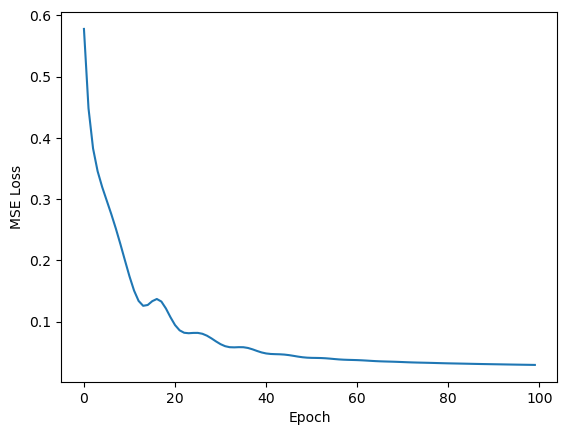

2


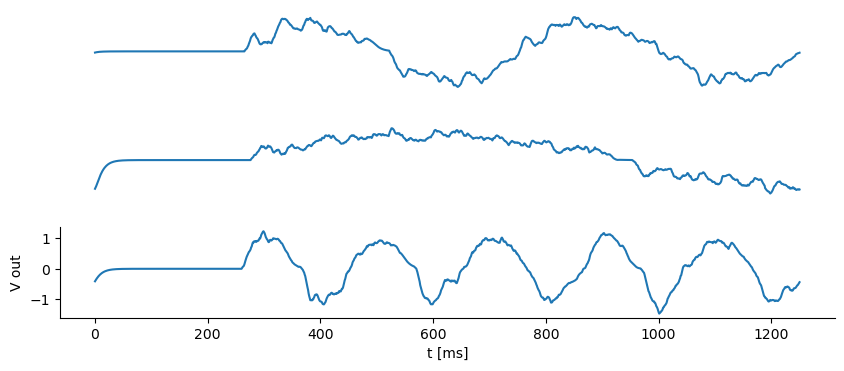

2


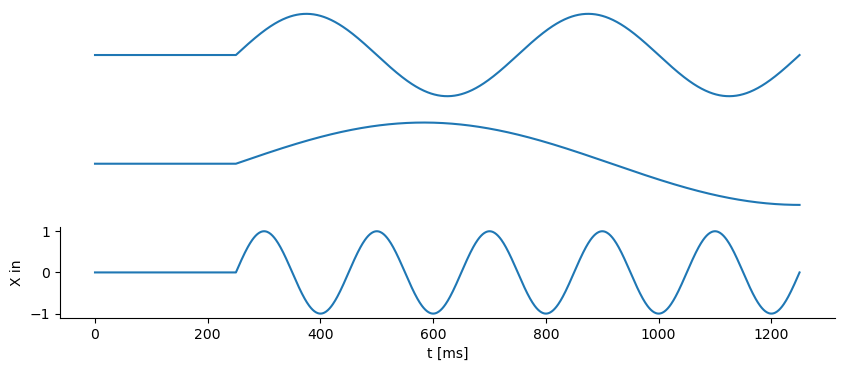

In [36]:
# make new readout layer
readout = Readout(100, 1, train_V_tau=True, train_I_tau=True)

# plot the initial reconstruction again
print('initial reconstruction')
V_outs = []
for spk in spikes.transpose(0, 1):
    V_out = readout(spk)
    V_outs.append(V_out)
V_outs = torch.stack(V_outs, 1)
plot_traces(V_outs, dim=(3, 1), ylabel='V out')
plt.show()

# define the parameters to be optimized
params = [p for p in readout.parameters() if p.requires_grad]
# let's use out-of-the-box Adam
optimizer = Adam(params, lr=5e-4)
losses = []

# iterate over the same batch 100 times
for e in range(100):
    readout.init_state(spikes.shape[0])

    # compute output
    V_outs = []
    for spk in spikes.transpose(0, 1):
        V_out = readout(spk)
        V_outs.append(V_out)
    V_outs = torch.stack(V_outs, 1)

    # compute loss
    loss = torch.pow(X - V_outs.transpose(0, 1), 2).mean()
    losses.append(loss.item())
    print(e, loss.item())

    # apply gradient
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot the loss development
plt.plot(losses)
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.show()

# finally, test the updated model again on the same training data
V_outs = []
for spk in spikes.transpose(0, 1):
    V_out = readout(spk)
    V_outs.append(V_out)
V_outs = torch.stack(V_outs, 1)

plot_traces(V_outs, dim=(3, 1), ylabel='V out')
plt.show()
plot_traces(X.transpose(0, 1), dim=(3, 1), ylabel='X in')
plt.show()

8. The output somewhat resembles the input to the spiking network now, only by training the readout layer. Next, we shall try to update also the input and recurrent weights of the SNN itself. But because the step activation function of the (fancy) LIF neurons is non-differentiable, we need to use a surrogate gradient function.

In [13]:
# This surrogate gradient function class is entirely taken from https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial1.ipynb

class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements
    the surrogate gradient. By subclassing torch.autograd.Function,
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid
    as this was done in Zenke & Ganguli (2018).
    """

    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which
        we need to later backpropagate our error signals. To achieve this we use the
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the
        surrogate gradient of the loss with respect to the input.
        Here we use the normalized negative part of a fast sigmoid
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad

# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

torch.Size([3, 1251, 100])


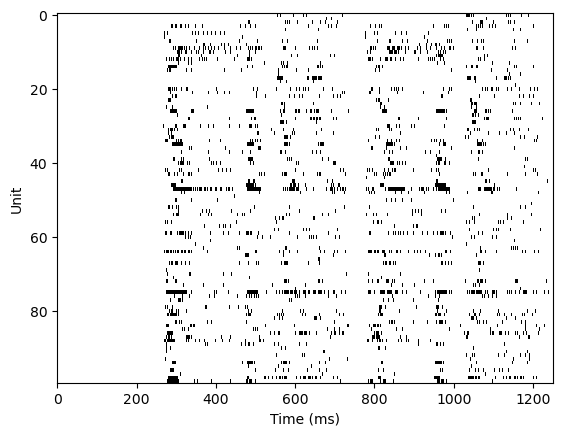

2


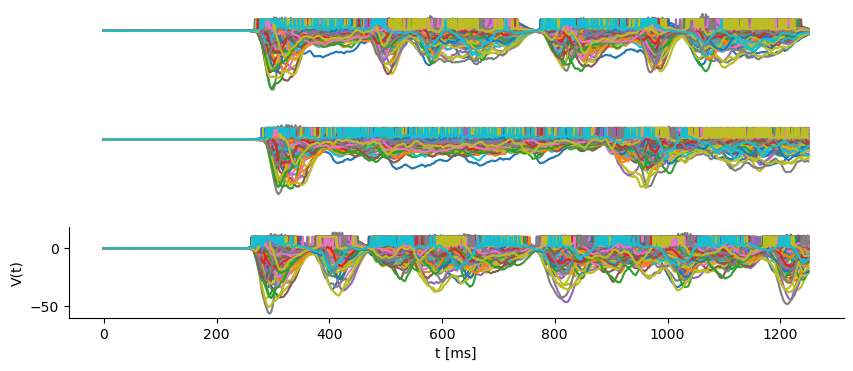

In [30]:
# Initiate the spiking model with 1 input and 100 hidden units
n_hidden = 100
flif = FLIF(1, n_hidden, bias=False, spike_func=spike_fn)
flif.init_state(batch_size)

verbose = False
if verbose:
    print(flif.spk)
    print(flif.V_t)
    print(flif.threshold_eff)
    print()

# Record some of the internal variables for plotting.
spikes = []
membrane = []
threshold = []
current = []

# Iterate over the time points in the data and feed it through the network
for t in range(T):
    spk = flif(X[t])
    spikes.append(spk)
    membrane.append(flif.V_t)
    threshold.append(flif.threshold_eff)
    current.append(flif.I_t)
    if verbose:
        print(t)
        print(flif.spk)
        print(flif.V_t)
        print(flif.threshold_eff)
        print()

# Turn the recorded variables into the right shape for easy plotting.
spikes = torch.stack(spikes, 1)
membrane = torch.stack(membrane, 1)
threshold = torch.stack(threshold, 1)
current = torch.stack(current, 1)
print(spikes.shape)

# plot the spikes
data_id = 0
raster_plot(spikes[data_id].detach())
plt.show()

# plot the membrane potential
plot_traces(membrane.detach(), spikes.detach(), dim=(3, 1))
plt.show()

initial reconstruction
2


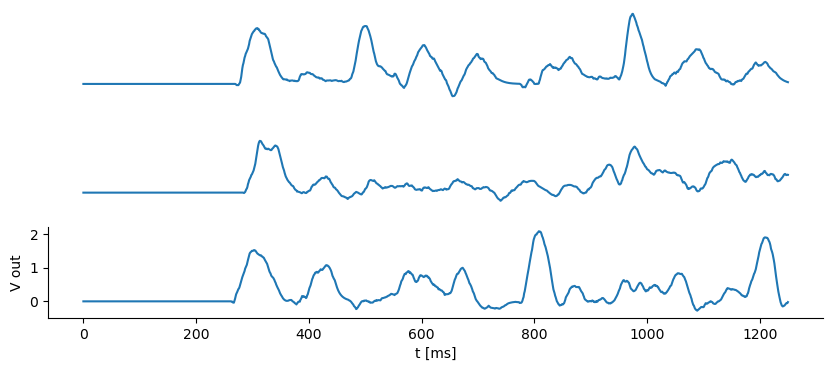

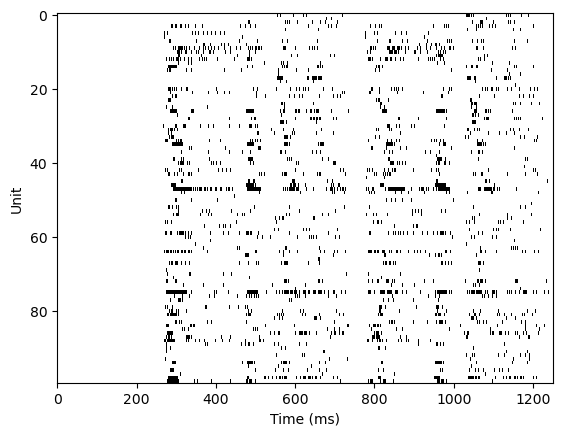

2


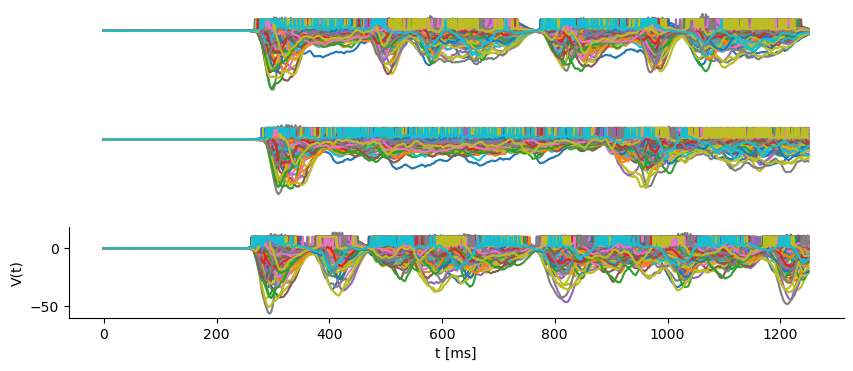

0 0.7868136763572693
1 0.6118218898773193
2 0.45102658867836
3 0.3744147717952728
4 0.3084854483604431
5 0.27163761854171753
6 0.257530152797699
7 0.22371695935726166
8 0.2079782336950302
9 0.17120496928691864
10 0.1355651468038559
11 0.14058108627796173
12 0.10532201081514359
13 0.11529590934515
14 0.1363239586353302
15 0.12540870904922485
16 0.10479796677827835
17 0.1333688199520111
18 0.1024971455335617
19 0.10395120829343796
20 0.08449406176805496
21 0.09451830387115479
22 0.07746894657611847
23 0.08500169962644577
24 0.07664462178945541
25 0.06970863789319992
26 0.0662822350859642
27 0.05805106833577156
28 0.06397376209497452
29 0.049888934940099716
30 0.05206872150301933
31 0.04904025048017502
32 0.0540311224758625
33 0.051238421350717545
34 0.05109885707497597
35 0.05524856597185135
36 0.050048284232616425
37 0.05027078464627266
38 0.05366251617670059
39 0.043755676597356796
40 0.0478530116379261
41 0.04694422334432602
42 0.04377444088459015
43 0.039041709154844284
44 0.04100755

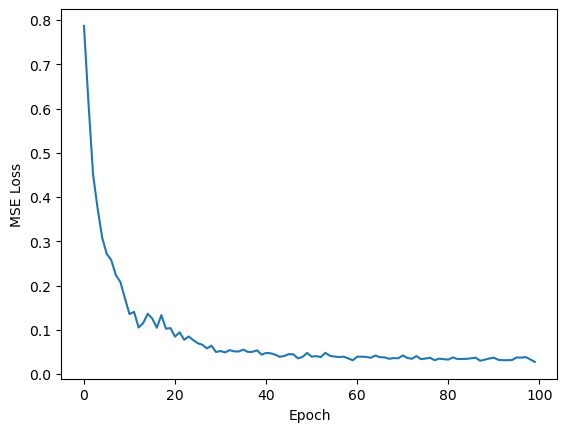

final reconstruction
2


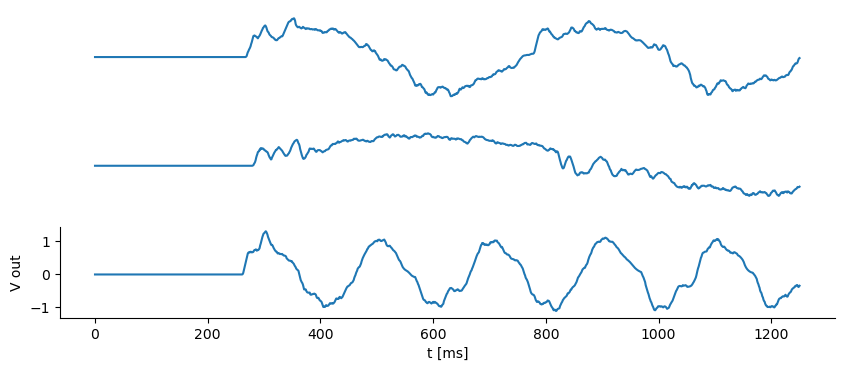

2


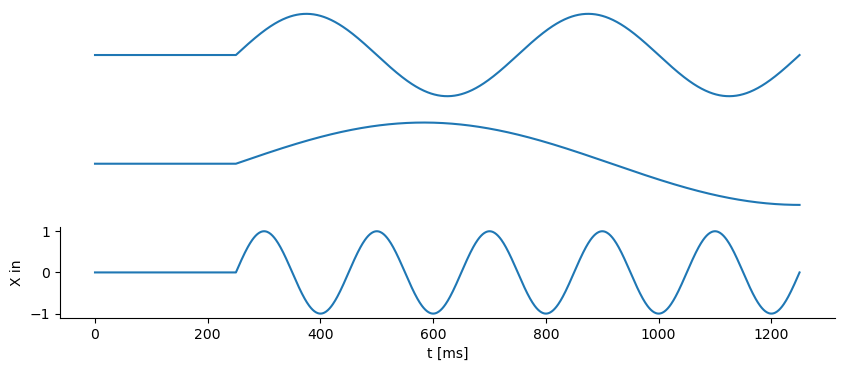

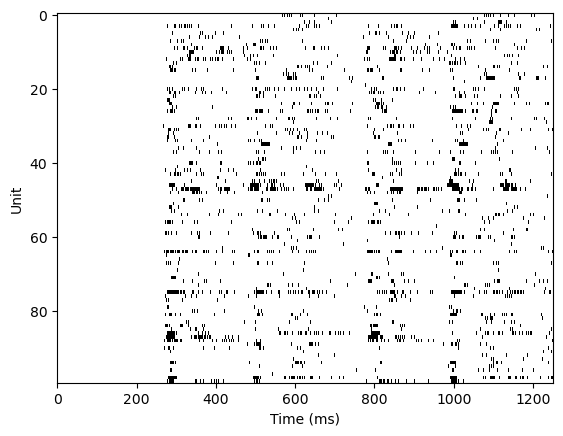

2


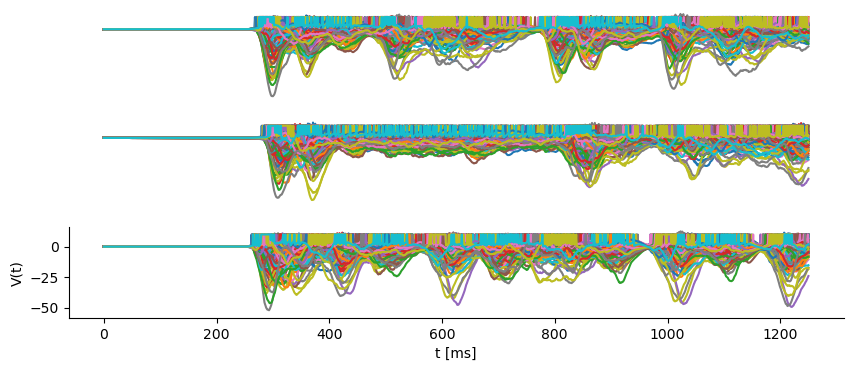

2


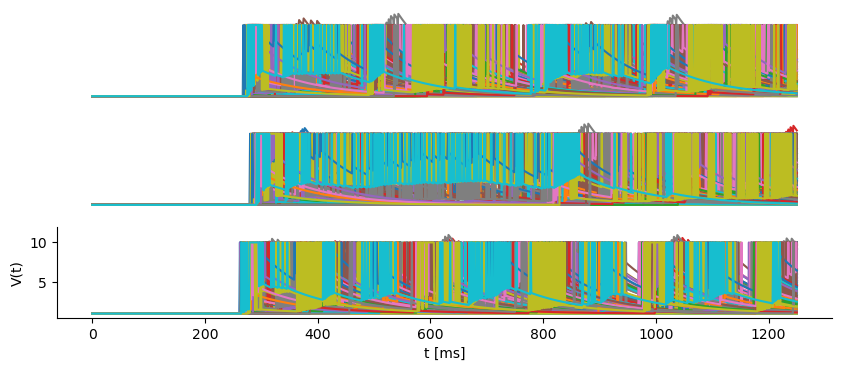

In [31]:
# make new readout layer
readout = Readout(100, 1)

batch_size = X.shape[1]

readout.init_state(batch_size)
flif.init_state(batch_size)

# plot the initial reconstruction again
print('initial reconstruction')

# Record some of the internal variables for plotting.
spikes = []
membrane = []
threshold = []
current = []
V_outs = []

# Iterate over the time points in the data and feed it through the network
for t in range(T):
    spk = flif(X[t])
    V_out = readout(spk)

    spikes.append(spk)
    membrane.append(flif.V_t)
    threshold.append(flif.threshold_eff)
    current.append(flif.I_t)
    V_outs.append(V_out)
    if verbose:
        print(t)
        print(flif.spk)
        print(flif.V_t)
        print(flif.threshold_eff)
        print()

# Turn the recorded variables into the right shape for easy plotting.
spikes = torch.stack(spikes, 1)
membrane = torch.stack(membrane, 1)
threshold = torch.stack(threshold, 1)
current = torch.stack(current, 1)
V_outs = torch.stack(V_outs, 1)
plot_traces(V_outs, dim=(3, 1), ylabel='V out')
plt.show()

# plot the spikes
data_id = 0
raster_plot(spikes[data_id].detach())
plt.show()

# plot the membrane potential
plot_traces(membrane.detach(), spikes.detach(), dim=(3, 1))
plt.show()

# define the parameters to be optimized
params = [p for p in readout.parameters() if p.requires_grad] + \
    [p for p in flif.parameters() if p.requires_grad]

# let's use out-of-the-box Adam
optimizer = Adam(params, lr=5e-4)
losses = []

# iterate over the same batch 100 times
for e in range(100):
    readout.init_state(batch_size)
    flif.init_state(batch_size)

    # Record some of the internal variables for plotting.
    spikes = []
    membrane = []
    threshold = []
    current = []
    V_outs = []

    # Iterate over the time points in the data and feed it through the network
    for t in range(T):
        spk = flif(X[t])
        V_out = readout(spk)

        spikes.append(spk)
        membrane.append(flif.V_t)
        threshold.append(flif.threshold_eff)
        current.append(flif.I_t)
        V_outs.append(V_out)
        if verbose:
            print(t)
            print(flif.spk)
            print(flif.V_t)
            print(flif.threshold_eff)
            print()

    # Turn the recorded variables into the right shape for easy plotting.
    spikes = torch.stack(spikes, 1)
    membrane = torch.stack(membrane, 1)
    threshold = torch.stack(threshold, 1)
    current = torch.stack(current, 1)
    V_outs = torch.stack(V_outs, 1)

    # compute loss
    loss = torch.pow(X - V_outs.transpose(0, 1), 2).mean()
    losses.append(loss.item())
    print(e, loss.item())

    # apply gradient
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot the loss development
plt.plot(losses)
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.show()

# finally, test the updated model again on the same training data
readout.init_state(batch_size)
flif.init_state(batch_size)

# plot the initial reconstruction again
print('final reconstruction')

# Record some of the internal variables for plotting.
spikes = []
membrane = []
threshold = []
current = []
V_outs = []

# Iterate over the time points in the data and feed it through the network
for t in range(T):
    spk = flif(X[t])
    V_out = readout(spk)

    spikes.append(spk)
    membrane.append(flif.V_t)
    threshold.append(flif.threshold_eff)
    current.append(flif.I_t)
    V_outs.append(V_out)
    if verbose:
        print(t)
        print(flif.spk)
        print(flif.V_t)
        print(flif.threshold_eff)
        print()

# Turn the recorded variables into the right shape for easy plotting.
spikes = torch.stack(spikes, 1)
membrane = torch.stack(membrane, 1)
threshold = torch.stack(threshold, 1)
current = torch.stack(current, 1)
V_outs = torch.stack(V_outs, 1)
plot_traces(V_outs, dim=(3, 1), ylabel='V out')
plt.show()
plot_traces(X.transpose(0, 1), dim=(3, 1), ylabel='X in')
plt.show()
# plot the spikes
data_id = 0
raster_plot(spikes[data_id].detach())
plt.show()

# plot the membrane potential
plot_traces(membrane.detach(), spikes.detach(), dim=(3, 1))
plt.show()

# plot the thresholds
plot_traces(threshold.detach(), spikes.detach(), dim=(3, 1))
plt.show()
